In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as de
import dedalus.extras.plot_tools as plot_tools
import atmospheres as atmos
import tides
import parameters as param
import mpi4py.MPI as MPI
import modes
import uuid
import logging
logger = logging.getLogger(__name__)
plt.style.use('thesis')
%matplotlib notebook

2018-05-24 23:58:12,312 matplotlib.backends 0/1 DEBUG :: backend nbAgg version unknown


In [2]:
import importlib
importlib.reload(param)

<module 'parameters' from '/Users/kburns/Hg/pg_coupling/compressible/notebooks/parameters.py'>

## Eigenmodes

In [6]:
# Solve dense to plot normalized modes
evals, evecs, adj_evals, adj_evecs, proj, sevp, pevp = modes.compute_eigenmodes(param, param.k_tide, sparse=False)

2018-05-25 00:00:00,543 domain 0/1 DEBUG :: Global coeff shape: [128]
2018-05-25 00:00:00,545 distributor 0/1 DEBUG :: Mesh: []
2018-05-25 00:00:00,547 problems 0/1 DEBUG :: Parsing Eqn 0
2018-05-25 00:00:00,548 problems 0/1 DEBUG ::   Condition: True
2018-05-25 00:00:00,549 problems 0/1 DEBUG ::   LHS string form: dz(pz) + (N2/g)*pz
2018-05-25 00:00:00,550 problems 0/1 DEBUG ::   RHS string form: pz*pz/p/γ
2018-05-25 00:00:00,552 problems 0/1 DEBUG ::   LHS object form: dz(pz) + ((N2*(g**-1))*pz)
2018-05-25 00:00:00,553 problems 0/1 DEBUG ::   RHS object form: ((pz*pz)*(p**-1))*(γ**-1)
2018-05-25 00:00:00,557 problems 0/1 DEBUG ::   L linear form: dz(δpz) + ((N2*(g**-1))*δpz)
2018-05-25 00:00:00,559 problems 0/1 DEBUG ::   dF linear form: ((((pz*pz)*(-1*(p**-2)))*(γ**-1))*δp) + ((((pz*(p**-1))*(γ**-1))*δpz) + (((pz*(p**-1))*(γ**-1))*δpz))
2018-05-25 00:00:00,560 problems 0/1 DEBUG :: Parsing Eqn 1
2018-05-25 00:00:00,561 problems 0/1 DEBUG ::   Condition: True
2018-05-25 00:00:00,562 

2018-05-25 00:00:01,696 problems 0/1 DEBUG ::   L linear form: (((U*(1j*kx))*p1) + (p0z*w)) + ((((γ*p0)*(1j*kx))*u) + ((γ*p0)*wz))
2018-05-25 00:00:01,698 problems 0/1 DEBUG :: Parsing Eqn 4
2018-05-25 00:00:01,699 problems 0/1 DEBUG ::   Condition: True
2018-05-25 00:00:01,700 problems 0/1 DEBUG ::   LHS string form: uz - dz(u)
2018-05-25 00:00:01,701 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-25 00:00:01,702 problems 0/1 DEBUG ::   LHS object form: uz + (-1*dz(u))
2018-05-25 00:00:01,703 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-25 00:00:01,706 problems 0/1 DEBUG ::   M linear form: 0
2018-05-25 00:00:01,707 problems 0/1 DEBUG ::   L linear form: uz + (-1*dz(u))
2018-05-25 00:00:01,708 problems 0/1 DEBUG :: Parsing Eqn 5
2018-05-25 00:00:01,710 problems 0/1 DEBUG ::   Condition: True
2018-05-25 00:00:01,711 problems 0/1 DEBUG ::   LHS string form: wz - dz(w)
2018-05-25 00:00:01,712 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-25 00:00:01,714 problems 0/1 DEBUG 

/Users/kburns/Hg/pg_coupling/compressible/notebooks/modes.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  energies[i] = E_op.evaluate()['c'][0]


<IPython.core.display.Javascript object>


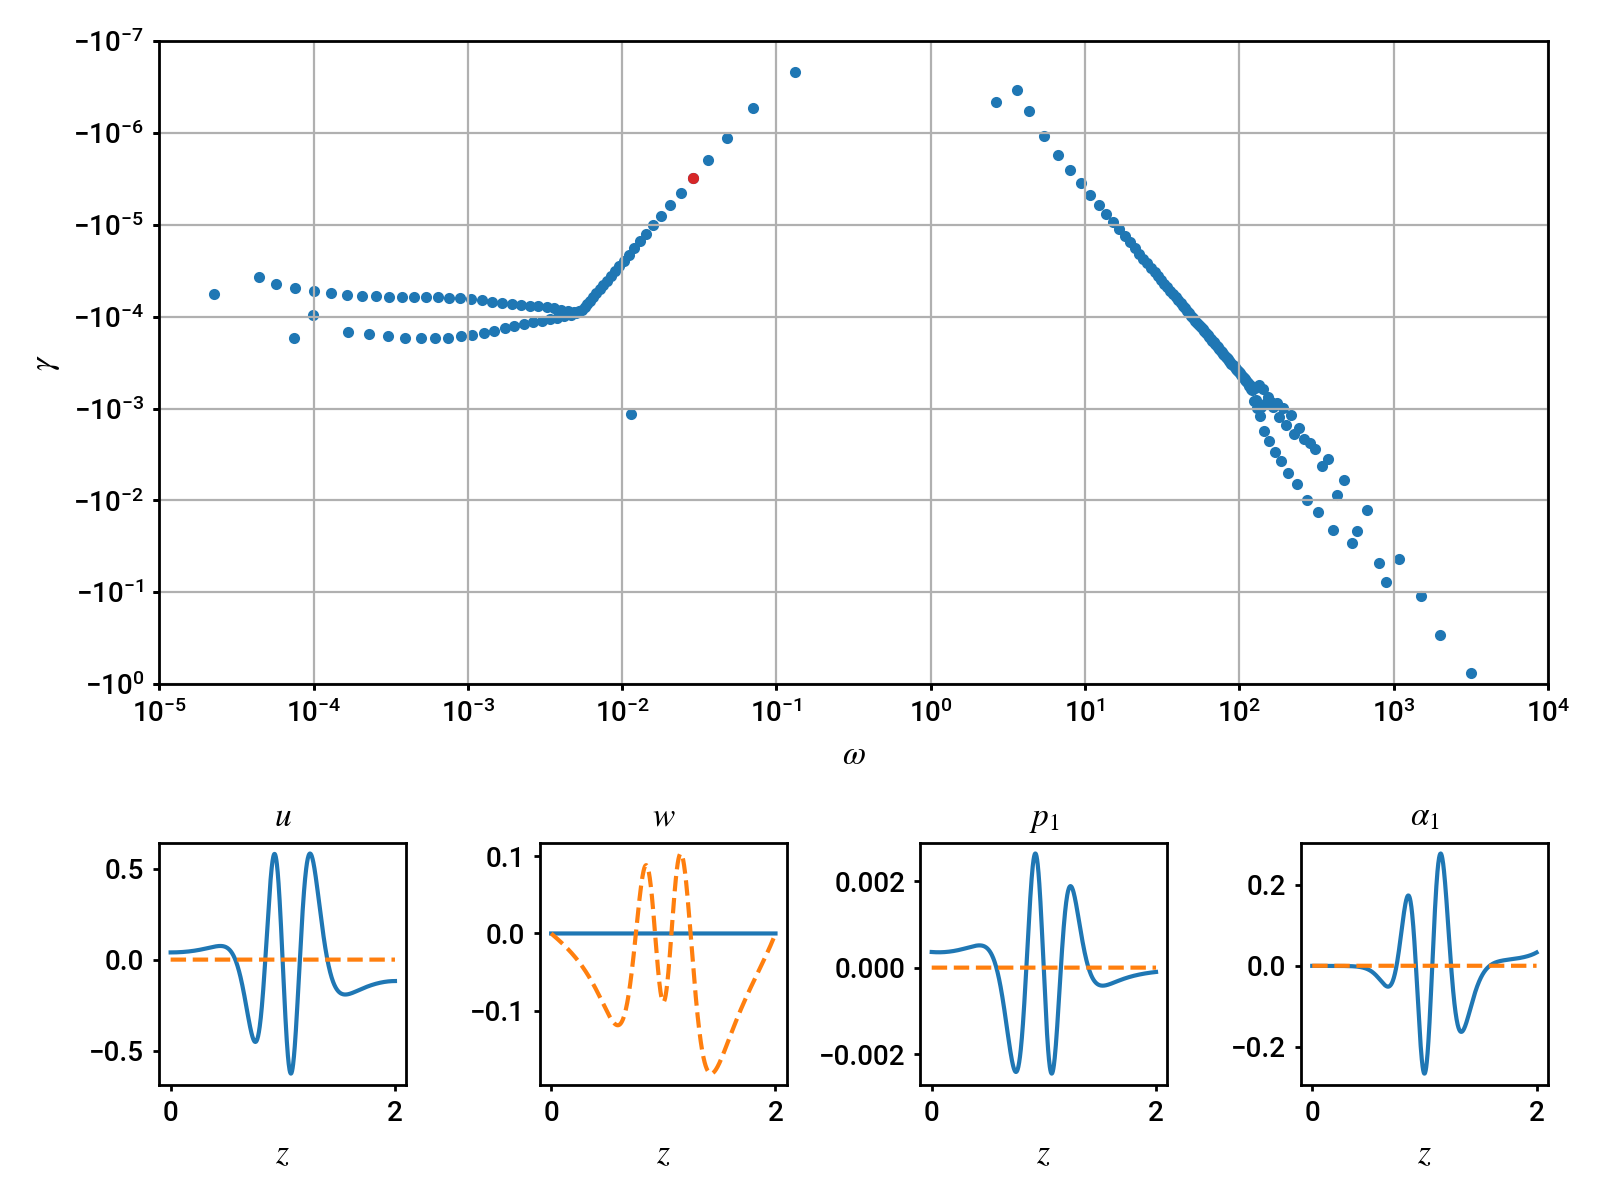

7

In [7]:
# Filter eigenvalues
evals = sevp.eigenvalues.copy()
freqs = 1j * evals

fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot2grid((3,4), (0,0), rowspan=2, colspan=4)
ax1.scatter(freqs.real, freqs.imag, marker='.', picker=2)
active_dot, = ax1.plot(0, 0, '.')
active_dot, = ax1.plot(0, 0, '.')
active_dot, = ax1.plot(0, 0, '.')
active_dot, = ax1.plot(0, 0, '.')
ax1.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$\gamma$')
active_ev = fig.suptitle('')

plt.xscale('symlog', linthreshx=1e-10)
plt.yscale('symlog', linthreshy=1e-10)
plt.grid()
plt.xlim([1e-5, 1e4])
plt.ylim([-1e0, -1e-7])

ax2 = plt.subplot2grid((3,4), (2,0))
ax3 = plt.subplot2grid((3,4), (2,1))
ax4 = plt.subplot2grid((3,4), (2,2))
ax5 = plt.subplot2grid((3,4), (2,3))

p0 = sevp.problem.namespace['p0']
a0 = sevp.problem.namespace['a0']
scales = 10
p0.set_scales(scales)
a0.set_scales(scales)
for field in sevp.state.fields:
    field.set_scales(scales)
z = sevp.domain.grid(0, scales=scales)

def plot_mode(event):
    # Update active eigenvalue
    x, y = event.mouseevent.xdata, event.mouseevent.ydata
    index = np.argmin(np.abs(freqs - (x + 1j*y)))
    ev = freqs[index]
    active_dot.set_xdata([ev.real])
    active_dot.set_ydata([ev.imag])
    #active_ev.set_text(r'$\omega = %.3e$' %ev)
    # Plot mode
    sevp.set_state(index)
    u = sevp.state['u']
    w = sevp.state['w']
    p1 = sevp.state['p1']
    a1 = sevp.state['a1']
    ρ1 = -a1['g'] / a0['g']**2
    phase = p1['g'][0]
    phase = phase / np.abs(phase)
    ax2.cla()
    ax2.plot(z, (u['g']/phase).real, '-')
    ax2.plot(z, (u['g']/phase).imag, '--')
    ax2.set_xlabel(r'$z$')
    ax2.set_title(r'$u$')
    ax3.cla()
    ax3.plot(z, (w['g']/phase).real, '-')
    ax3.plot(z, (w['g']/phase).imag, '--')
    ax3.set_xlabel(r'$z$')
    ax3.set_title(r'$w$')
    ax4.cla()
    ax4.plot(z, (p1['g']/phase).real, '-')
    ax4.plot(z, (p1['g']/phase).imag, '--')
    ax4.set_xlabel(r'$z$')
    ax4.set_title(r'$p_1$')
    ax5.cla()
    ax5.plot(z, (a1['g']/phase).real, '-')
    ax5.plot(z, (a1['g']/phase).imag, '--')
    ax5.set_xlabel(r'$z$')
    ax5.set_title(r'$\alpha_1$')
    fig.tight_layout()
    
fig.canvas.mpl_connect('pick_event', plot_mode)

In [8]:
plt.savefig('eigenmodes.pdf')

2018-05-25 00:03:18,185 matplotlib.backends.backend_pdf 0/1 DEBUG :: Assigning font /b'F1' = '/Library/Fonts/Roboto-Medium.ttf'
2018-05-25 00:03:18,316 matplotlib.backends.backend_pdf 0/1 DEBUG :: Assigning font /b'F2' = '/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf'
2018-05-25 00:03:18,591 matplotlib.backends.backend_pdf 0/1 DEBUG :: Assigning font /b'F3' = '/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf'
2018-05-25 00:03:18,612 matplotlib.backends.backend_pdf 0/1 DEBUG :: Embedding font /Library/Fonts/Roboto-Medium.ttf.
2018-05-25 00:03:18,613 matplotlib.backends.backend_pdf 0/1 DEBUG :: Writing TrueType font.
2018-05-25 00:03:18,627 matplotlib.backends.backend_pdf 0/1 DEBUG :: Embedding font /usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf.
2018-05-25 00:03:18,628 matplotlib.backends.backend_pdf 0/1 DEBUG :: Writing TrueType font.
2018-05-25 00:03:18,639 matplotlib

## Linear tide

In [3]:
# Solve tide
param.A_tide = 1
domain, problem = tides.linear_tide_1d(param)
solver = problem.build_solver()
solver.solve()

2018-05-24 23:58:18,627 domain 0/1 DEBUG :: Global coeff shape: [128]
2018-05-24 23:58:18,629 distributor 0/1 DEBUG :: Mesh: []
2018-05-24 23:58:18,632 problems 0/1 DEBUG :: Parsing Eqn 0
2018-05-24 23:58:18,633 problems 0/1 DEBUG ::   Condition: True
2018-05-24 23:58:18,634 problems 0/1 DEBUG ::   LHS string form: dz(pz) + (N2/g)*pz
2018-05-24 23:58:18,635 problems 0/1 DEBUG ::   RHS string form: pz*pz/p/γ
2018-05-24 23:58:18,637 problems 0/1 DEBUG ::   LHS object form: dz(pz) + ((N2*(g**-1))*pz)
2018-05-24 23:58:18,637 problems 0/1 DEBUG ::   RHS object form: ((pz*pz)*(p**-1))*(γ**-1)
2018-05-24 23:58:18,642 problems 0/1 DEBUG ::   L linear form: dz(δpz) + ((N2*(g**-1))*δpz)
2018-05-24 23:58:18,644 problems 0/1 DEBUG ::   dF linear form: ((((pz*pz)*(-1*(p**-2)))*(γ**-1))*δp) + ((((pz*(p**-1))*(γ**-1))*δpz) + (((pz*(p**-1))*(γ**-1))*δpz))
2018-05-24 23:58:18,645 problems 0/1 DEBUG :: Parsing Eqn 1
2018-05-24 23:58:18,646 problems 0/1 DEBUG ::   Condition: True
2018-05-24 23:58:18,647 

2018-05-24 23:58:19,642 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-24 23:58:19,643 problems 0/1 DEBUG ::   L linear form: wz + (-1*dz(w))
2018-05-24 23:58:19,644 problems 0/1 DEBUG :: Parsing BC 0
2018-05-24 23:58:19,645 problems 0/1 DEBUG ::   Condition: True
2018-05-24 23:58:19,646 problems 0/1 DEBUG ::   LHS string form: left(txz/μ)
2018-05-24 23:58:19,646 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-24 23:58:19,647 problems 0/1 DEBUG ::   LHS object form: interp((μ*(((1j*k)*w) + uz))*(μ**-1),'z',left)
2018-05-24 23:58:19,648 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-24 23:58:19,652 problems 0/1 DEBUG ::   L linear form: interp(((μ*(1j*k))*(μ**-1))*w,'z',left) + interp((μ*(μ**-1))*uz,'z',left)
2018-05-24 23:58:19,653 problems 0/1 DEBUG :: Parsing BC 1
2018-05-24 23:58:19,654 problems 0/1 DEBUG ::   Condition: True
2018-05-24 23:58:19,654 problems 0/1 DEBUG ::   LHS string form: right(txz/μ)
2018-05-24 23:58:19,655 problems 0/1 DEBUG ::   RHS string form: 0
201

Check L.X = b: True
X == X_recon: False
|X - X_recon|/|X|: 3.040812300145087e-06


<IPython.core.display.Javascript object>


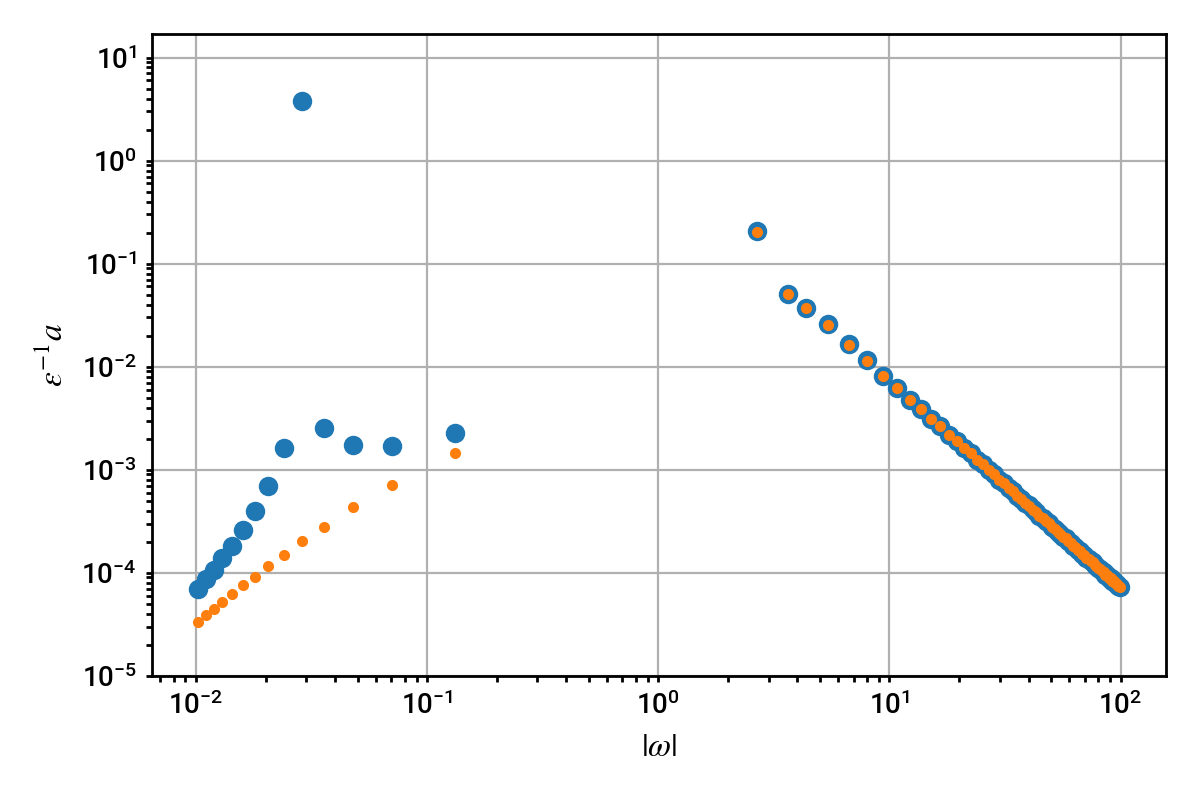

2018-05-25 00:03:23,973 matplotlib.backends.backend_pdf 0/1 DEBUG :: Assigning font /b'F1' = '/Library/Fonts/Roboto-Medium.ttf'
2018-05-25 00:03:24,026 matplotlib.backends.backend_pdf 0/1 DEBUG :: Assigning font /b'F2' = '/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf'
2018-05-25 00:03:24,027 matplotlib.backends.backend_pdf 0/1 DEBUG :: Assigning font /b'F3' = '/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf'
2018-05-25 00:03:24,131 matplotlib.backends.backend_pdf 0/1 DEBUG :: Embedding font /Library/Fonts/Roboto-Medium.ttf.
2018-05-25 00:03:24,131 matplotlib.backends.backend_pdf 0/1 DEBUG :: Writing TrueType font.
2018-05-25 00:03:24,140 matplotlib.backends.backend_pdf 0/1 DEBUG :: Embedding font /usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf.
2018-05-25 00:03:24,141 matplotlib.backends.backend_pdf 0/1 DEBUG :: Writing TrueType font.
2018-05-25 00:03:24,151 matplotlib

In [9]:
# Construct RHS
p = solver.pencils[0]
pFe = solver.Fe.get_pencil(p)
pFb = solver.Fb.get_pencil(p)
b = p.G_eq * pFe + p.G_bc * pFb
X = solver.state.get_pencil(p).copy()
print('Check L.X = b:', np.allclose(p.L@X, b))

# Bias evals by tidal frequency, which is left out of EVP
freqs = 1j * evals
filt = (np.abs(freqs.real) > 1e-2) * (np.abs(freqs.real) < 1e2)
lam = evals - (-1j*param.ω_tide)
amps_proj = - adj_evecs[:,filt].T.conj() @ b / lam[filt]
X_recon = evecs[:,filt] @ amps_proj
dX = X - X_recon

print('X == X_recon:', np.allclose(X, X_recon))
print('|X - X_recon|/|X|:', (np.dot(dX, dX.conj()) / np.dot(X, X.conj())).real)

freq = 1j * evals
plt.figure(figsize=(6,4))
plt.loglog(freqs[filt].real, np.abs(amps_proj), 'o')
plt.loglog(-freqs[filt].real, np.abs(amps_proj), '.')
plt.grid()
plt.ylim([1e-5, None])
plt.xlabel(r'$|\omega|$')
plt.ylabel(r'$\epsilon^{-1} a$')
plt.tight_layout()
plt.savefig('linear_amps.pdf')

In [4]:
domain2, problem2 = tides.linear_tide_2d(param)
solver2 = problem2.build_solver()
for f in solver2.state.field_names:
    solver2.state[f]['c'][2,:] = solver.state[f]['c']

2018-05-24 23:58:21,866 domain 0/1 DEBUG :: Global coeff shape: [128]
2018-05-24 23:58:21,867 distributor 0/1 DEBUG :: Mesh: []
2018-05-24 23:58:21,870 problems 0/1 DEBUG :: Parsing Eqn 0
2018-05-24 23:58:21,870 problems 0/1 DEBUG ::   Condition: True
2018-05-24 23:58:21,871 problems 0/1 DEBUG ::   LHS string form: dz(pz) + (N2/g)*pz
2018-05-24 23:58:21,872 problems 0/1 DEBUG ::   RHS string form: pz*pz/p/γ
2018-05-24 23:58:21,874 problems 0/1 DEBUG ::   LHS object form: dz(pz) + ((N2*(g**-1))*pz)
2018-05-24 23:58:21,875 problems 0/1 DEBUG ::   RHS object form: ((pz*pz)*(p**-1))*(γ**-1)
2018-05-24 23:58:21,879 problems 0/1 DEBUG ::   L linear form: dz(δpz) + ((N2*(g**-1))*δpz)
2018-05-24 23:58:21,882 problems 0/1 DEBUG ::   dF linear form: ((((pz*pz)*(-1*(p**-2)))*(γ**-1))*δp) + ((((pz*(p**-1))*(γ**-1))*δpz) + (((pz*(p**-1))*(γ**-1))*δpz))
2018-05-24 23:58:21,883 problems 0/1 DEBUG :: Parsing Eqn 1
2018-05-24 23:58:21,884 problems 0/1 DEBUG ::   Condition: True
2018-05-24 23:58:21,884 

2018-05-24 23:58:22,778 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-24 23:58:22,779 problems 0/1 DEBUG ::   LHS object form: wz + (-1*dz(w))
2018-05-24 23:58:22,780 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-24 23:58:22,781 problems 0/1 DEBUG ::   L linear form: wz + (-1*dz(w))
2018-05-24 23:58:22,782 problems 0/1 DEBUG :: Parsing BC 0
2018-05-24 23:58:22,783 problems 0/1 DEBUG ::   Condition: True
2018-05-24 23:58:22,783 problems 0/1 DEBUG ::   LHS string form: left(txz/μ)
2018-05-24 23:58:22,784 problems 0/1 DEBUG ::   RHS string form: 0
2018-05-24 23:58:22,786 problems 0/1 DEBUG ::   LHS object form: interp((μ*(dx(w) + uz))*(μ**-1),'z',left)
2018-05-24 23:58:22,787 problems 0/1 DEBUG ::   RHS object form: 0
2018-05-24 23:58:22,790 problems 0/1 DEBUG ::   L linear form: interp((μ*(μ**-1))*dx(w),'z',left) + interp((μ*(μ**-1))*uz,'z',left)
2018-05-24 23:58:22,792 problems 0/1 DEBUG :: Parsing BC 1
2018-05-24 23:58:22,793 problems 0/1 DEBUG ::   Condition: True
2018-05-24

<IPython.core.display.Javascript object>


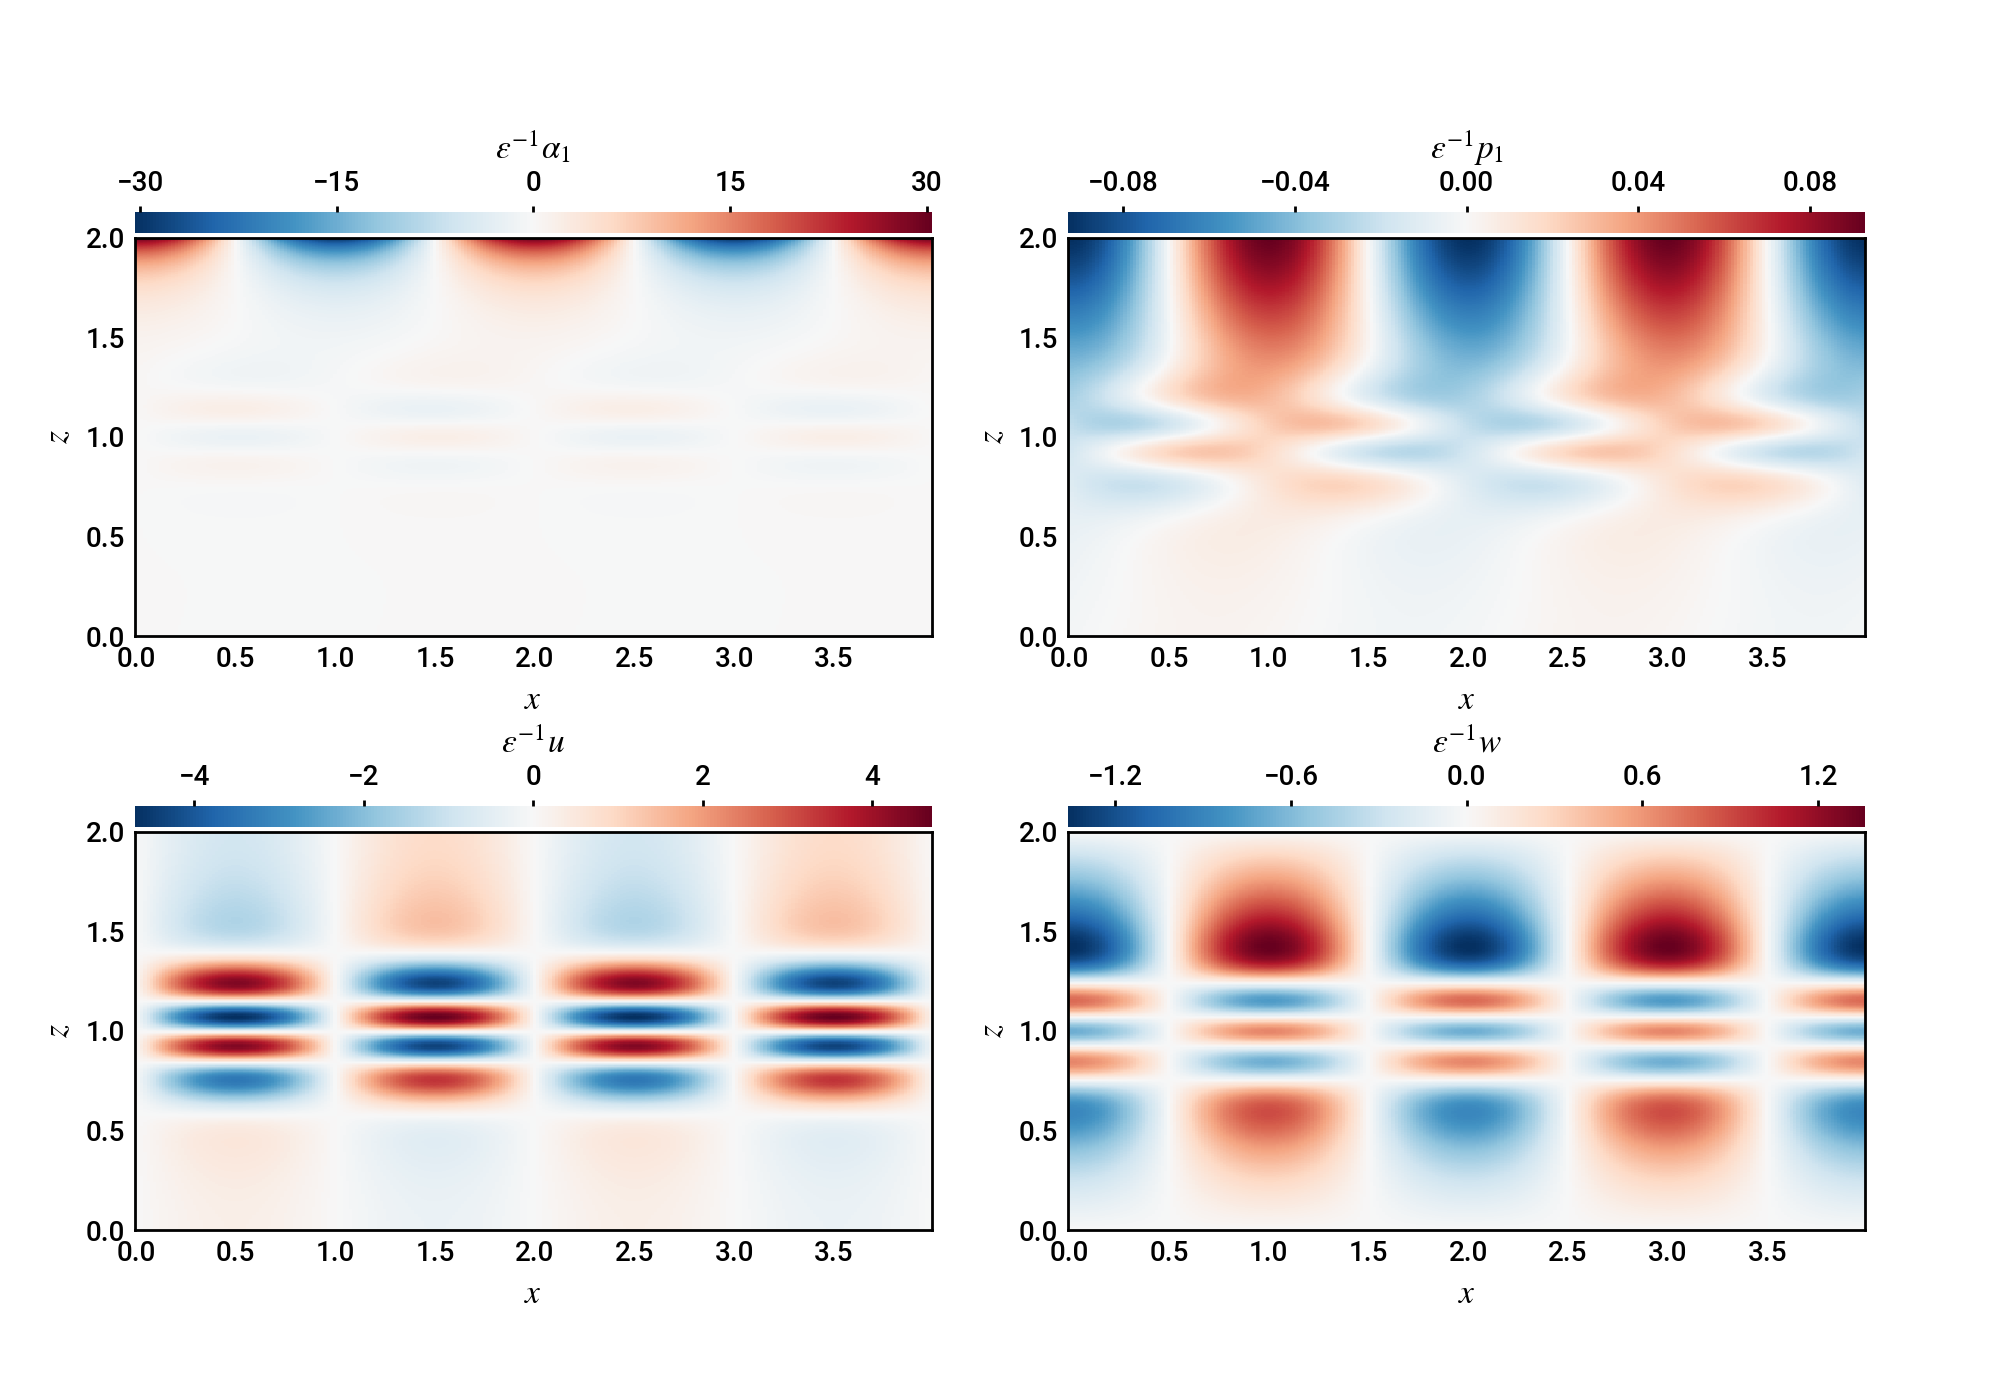

In [13]:
# Plot settings
tasks = ['a1', 'p1', 'u', 'w']
titles = [r'$\epsilon^{-1} \alpha_1$', r'$\epsilon^{-1} p_1$', r'$\epsilon^{-1} u$', r'$\epsilon^{-1} w$']
scale = 2
dpi = 100
title_func = lambda sim_time: 't = {:.3f}'.format(sim_time)
savename_func = lambda write: 'write_{:06}.png'.format(write)
# Layout
nrows, ncols = 2, 2
image = plot_tools.Box(2, 1)
pad = plot_tools.Frame(0.2, 0.2, 0.1, 0.1)
margin = plot_tools.Frame(0.3, 0.2, 0.1, 0.1)

# Create multifigure
mfig = plot_tools.MultiFigure(nrows, ncols, image, pad, margin, scale)
fig = mfig.figure
# Plot writes
for n, (task, title) in enumerate(zip(tasks, titles)):
    # Build subfigure axes
    i, j = divmod(n, ncols)
    axes = mfig.add_axes(i, j, [0, 0, 1, 1])
    # Call 3D plotting helper, slicing in time
    dset = solver2.state[task]
    dset.set_scales(4)
    dset.require_grid_space()
    pax, cax = plot_tools.plot_bot_2d(dset, axes=axes, title=task, even_scale=True)
    pax.set_xlabel(r'$x$')
    pax.set_ylabel(r'$z$')
    cax.set_xlabel(title)
plt.savefig('linear_fields.png')